In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors

In [2]:
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database               import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.io.dst_io              import load_dst
from   invisible_cities.core.stat_functions    import poisson_sigma

import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d

In [3]:
import antea.database.load_db as db

In [7]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue         = tableau20[ 0]
green        = tableau20[ 4]
red          = tableau20[ 6]
pink         = tableau20[ 7]
purple       = tableau20[ 8]
light_purple = tableau20[ 9]
brown        = tableau20[10]
grey         = tableau20[15]

color_nice = '#029386'

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 13, 11

colors = [blue, green, red, purple, brown, grey]
linestyle = ['-', '-.', ':','-','--', ':']

In [8]:
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

In [9]:
## functions to fit
def twogauss(x, amp0, mu0, sigma0, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def threegauss(x, amp0, mu0, sigma0, amp1, mu1, sigma1, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [10]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f mm
        $\sigma$ = %.3f +/- %.3f mm
        FWHM res. = %.3f mm
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

def gtext_angle(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f deg
        $\sigma$ = %.3f +/- %.3f deg
        FWHM res. = %.3f deg
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

In [11]:
true_r1, true_phi1, true_z1 = [], [], []
reco_r1, reco_phi1, reco_z1 = [], [], []
true_r2, true_phi2, true_z2 = [], [], []
reco_r2, reco_phi2, reco_z2 = [], [], []
events = []
sns_response1, sns_response2 = [],[]
true_t1, true_t2 = [], []
sipm_t1, sipm_t2 = [], []
first_sipm1, first_sipm2 = [], []
phot1, phot2, phot_like1, phot_like2 = [], [], [], []
true_dep_e1, true_dep_e2 = [], []

file_base = '/data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_{0}_{1}_2_4_4_2.npz'

bunch = 20
for f in range(16000, 17000, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
    
    #print(list(d.keys()))
    #print(d['a_true_r1'])
            
    true_r1   = np.concatenate((true_r1,   d['a_true_r1']))
    true_phi1 = np.concatenate((true_phi1, d['a_true_phi1']))
    true_z1   = np.concatenate((true_z1,   d['a_true_z1']))   
        
    reco_r1   = np.concatenate((reco_r1,   d['a_reco_r1']))
    reco_phi1 = np.concatenate((reco_phi1, d['a_reco_phi1']))  
    reco_z1   = np.concatenate((reco_z1,   d['a_reco_z1']))  
    
    true_r2   = np.concatenate((true_r2,   d['a_true_r2']))
    true_phi2 = np.concatenate((true_phi2, d['a_true_phi2']))
    true_z2   = np.concatenate((true_z2,   d['a_true_z2']))   
        
    reco_r2   = np.concatenate((reco_r2,   d['a_reco_r2']))
    reco_phi2 = np.concatenate((reco_phi2, d['a_reco_phi2']))  
    reco_z2   = np.concatenate((reco_z2,   d['a_reco_z2']))  
    
    true_t1 = np.concatenate((true_t1, d['a_true_time1']))
    true_t2 = np.concatenate((true_t2, d['a_true_time2']))
    
    sipm_t1 = np.concatenate((sipm_t1, d['a_first_time1']))
    sipm_t2 = np.concatenate((sipm_t2, d['a_first_time2']))
    
    first_sipm1 = np.concatenate((first_sipm1, d['a_first_sipm1']))
    first_sipm2 = np.concatenate((first_sipm2, d['a_first_sipm2']))
    
    sns_response1 = np.concatenate((sns_response1, d['a_sns_response1']))
    sns_response2 = np.concatenate((sns_response2, d['a_sns_response2']))
    
    phot1       = np.concatenate((phot1, d['a_photo1']))
    phot2       = np.concatenate((phot2, d['a_photo2']))
    phot_like1  = np.concatenate((phot_like1, d['a_photo_like1']))
    phot_like2  = np.concatenate((phot_like2, d['a_photo_like2']))
    true_dep_e1 = np.concatenate((true_dep_e1, d['a_hit_energy1']))
    true_dep_e2 = np.concatenate((true_dep_e2, d['a_hit_energy2']))
    
    events = np.concatenate((events, d['a_event_ids']))

        
true_r1   = np.array(true_r1)
true_phi1 = np.array(true_phi1)
true_z1   = np.array(true_z1)

reco_r1   = np.array(reco_r1)
reco_phi1 = np.array(reco_phi1)
reco_z1   = np.array(reco_z1)

true_r2   = np.array(true_r2)
true_phi2 = np.array(true_phi2)
true_z2   = np.array(true_z2)

reco_r2   = np.array(reco_r2)
reco_phi2 = np.array(reco_phi2)
reco_z2   = np.array(reco_z2)

true_t1 = np.array(true_t1) 
sipm_t1 = np.array(sipm_t1)
true_t2 = np.array(true_t2)
sipm_t2 = np.array(sipm_t2)
first_sipm1 = np.array(first_sipm1)
first_sipm2 = np.array(first_sipm2)

sns_response1 = np.array(sns_response1)
sns_response2 = np.array(sns_response2)

phot1 = np.array(phot1)
phot2 = np.array(phot2)
phot_like1 = np.array(phot_like1)
phot_like2 = np.array(phot_like2)
true_dep_e1 = np.array(true_dep_e1)
true_dep_e2 = np.array(true_dep_e2)

events = np.array(events)

true_x1 = true_r1 * np.cos(true_phi1)
reco_x1 = reco_r1 * np.cos(reco_phi1)
true_y1 = true_r1 * np.sin(true_phi1)
reco_y1 = reco_r1 * np.sin(reco_phi1)
true_x2 = true_r2 * np.cos(true_phi2)
reco_x2 = reco_r2 * np.cos(reco_phi2)
true_y2 = true_r2 * np.sin(true_phi2)
reco_y2 = reco_r2 * np.sin(reco_phi2)

File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16000_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16020_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16040_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16060_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16080_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16100_20_2_4_4_2.npz not found
File /data4/NEXT/users/paolafer/dev_area/ic_dev/petalo/full_body/phantom/full_body_phantom_coincidences_phot_info_16120_20_2_4_4_2

In [10]:
print('Number of reconstructed coincidences: {0}'.format(len(events)))

Number of reconstructed coincidences: 171196


In [11]:
### change by hand phi reconstructed as true=~3.14, reco~=-3.14
reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.] = -reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.]
reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.] = -reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.]

diff_x1   = reco_x1 - true_x1
diff_y1   = reco_y1 - true_y1
diff_r1   = reco_r1 - true_r1
diff_phi1 = reco_phi1 - true_phi1
diff_z1   = reco_z1 - true_z1

diff_x2   = reco_x2 - true_x2
diff_y2   = reco_y2 - true_y2
diff_r2   = reco_r2 - true_r2
diff_phi2 = reco_phi2 - true_phi2
diff_z2   = reco_z2 - true_z2

true_x = np.concatenate((true_x1, true_x2))
true_y = np.concatenate((true_y1, true_y2))
reco_x = np.concatenate((reco_x1, reco_x2))
reco_y = np.concatenate((reco_y1, reco_y2))

true_r   = np.concatenate((true_r1, true_r2))
true_phi = np.concatenate((true_phi1, true_phi2))
true_z   = np.concatenate((true_z1, true_z2))
reco_r   = np.concatenate((reco_r1, reco_r2))
reco_phi = np.concatenate((reco_phi1, reco_phi2))
reco_z   = np.concatenate((reco_z1, reco_z2))

true_t = np.concatenate((true_t1, true_t2))

diff_r = np.concatenate((diff_r1, diff_r2))
diff_phi = np.concatenate((diff_phi1, diff_phi2))
diff_z = np.concatenate((diff_z1, diff_z2))
diff_x = np.concatenate((diff_x1, diff_x2))
diff_y = np.concatenate((diff_y1, diff_y2))

sns_response = np.concatenate((sns_response1, sns_response2))
phot      = np.concatenate((phot1, phot2))
phot_like = np.concatenate((phot_like1, phot_like2))
true_dep_e = np.concatenate((true_dep_e1, true_dep_e2))

n_int = len(true_x) # number of interactions

In [12]:
d1 = true_r1 - reco_r1
d2 = true_r2 - reco_r2
diff_r_matrix = np.concatenate((d1, d2))

d1_phi = true_phi1 - reco_phi1
d2_phi = true_phi2 - reco_phi2
diff_phi_matrix = np.concatenate((d1_phi, d2_phi))

d1_z = true_z1 - reco_z1
d2_z = true_z2 - reco_z2
diff_z_matrix = np.concatenate((d1_z, d2_z))

In [13]:
### read sensor positions from database
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

speed_in_vacuum = 0.299792458# * units.mm / units.ps
ave_speed_in_LXe = 0.210 #* units.mm / units.ps

In [14]:
### Positions
pos_1 = np.array([reco_x1, reco_y1, reco_z1]).transpose()
pos_2 = np.array([reco_x2, reco_y2, reco_z2]).transpose()
sipm_pos_1 = np.array([DataSiPM_idx.loc[first_sipm1].X, DataSiPM_idx.loc[first_sipm1].Y, DataSiPM_idx.loc[first_sipm1].Z]).transpose()
sipm_pos_2 = np.array([DataSiPM_idx.loc[first_sipm2].X, DataSiPM_idx.loc[first_sipm2].Y, DataSiPM_idx.loc[first_sipm2].Z]).transpose()

### Distance of the interaction point from the SiPM seeing the first photon
dist1 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1), axis=1)
dist2 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2), axis=1)

In [15]:
d1_t = true_t1 - sipm_t1
d2_t = true_t2 - sipm_t2
diff_t_matrix = np.concatenate((d1_t, d2_t))

reco_t1 = sipm_t1 - (dist1/ave_speed_in_LXe)
reco_t2 = sipm_t2 - (dist2/ave_speed_in_LXe)
d1_reco_t = true_t1 - reco_t1
d2_reco_t = true_t2 - reco_t2
diff_reco_t_matrix = np.concatenate((d1_reco_t, d2_reco_t))

In [118]:
print('Fraction of photoelectric interactions = {0}'.format(len(phot[phot == True])/n_int))
print('Fraction of not photoelectric interactions = {0}'.format(len(phot[phot == False])/n_int))

Fraction of photoelectric interactions = 0.05421215443451048
Fraction of not photoelectric interactions = 0.9457878455654896


In [169]:
print('Fraction of photo-like interactions = {0}'.format(len(phot_like[phot_like == True])/n_int))
print('Fraction of not photo-like interactions = {0}'.format(len(phot_like[phot_like == False])/n_int))

print('Fraction of true photo not recognized as such = {0}'.format(len(phot[(phot == True) & (phot_like == False)])/n_int))
print('Fraction of not true photo that looks like photo = {0}'.format(len(phot_like[(phot == False) & (phot_like == True)])/n_int))

Fraction of photo-like interactions = 0.33034788221102357
Fraction of not photo-like interactions = 0.6696521177889765
Fraction of true photo not recognized as such = 0.004147125361232305
Fraction of not true photo that looks like photo = 0.2804416898719669


In [16]:
sel_phot_like  = (phot_like == True)
sel_compt_like = (phot_like == False)

## Some inspection of photoelectrics

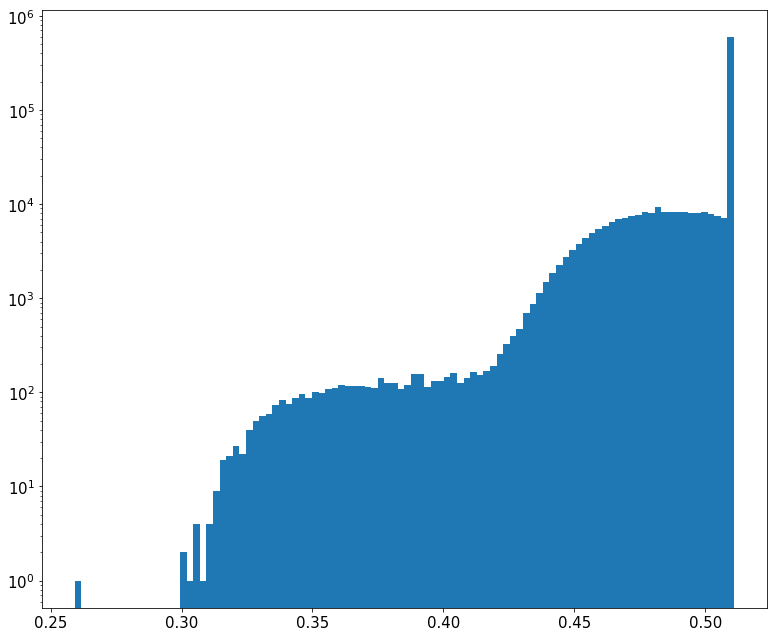

In [121]:
good_e = true_dep_e[sel_phot_like]
h = plt.hist(good_e, bins=100);
plt.yscale('log')

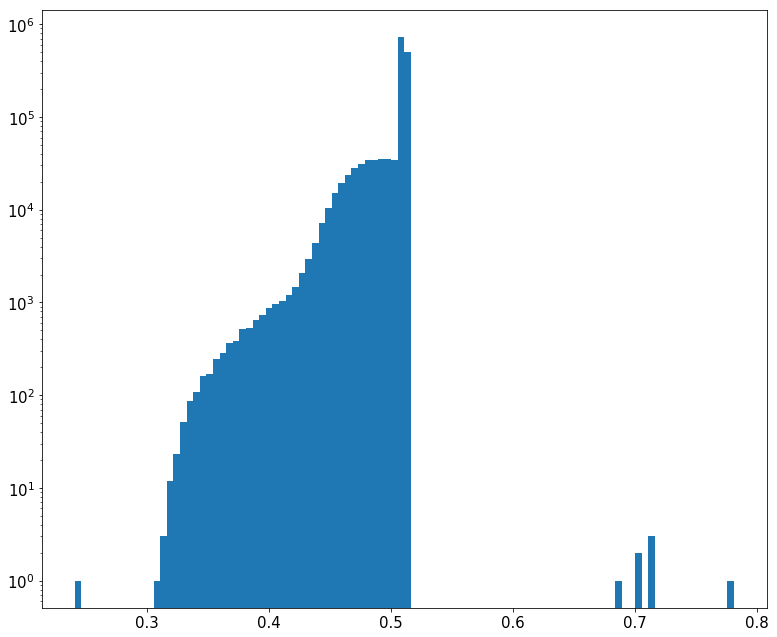

In [122]:
bad_e = true_dep_e[sel_compt_like]
h = plt.hist(bad_e, bins=100);
plt.yscale('log')

## Error matrices

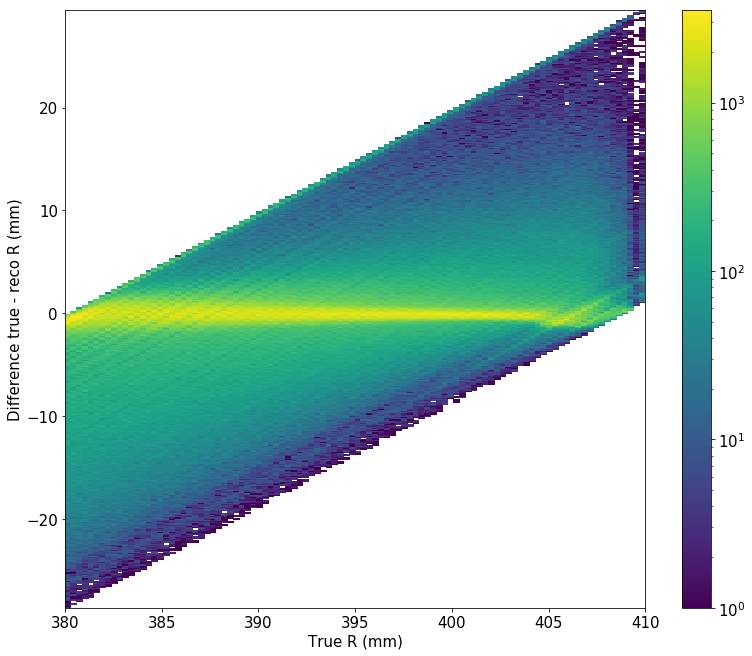

In [170]:
## all events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();
#plt.ylim(-5,5)

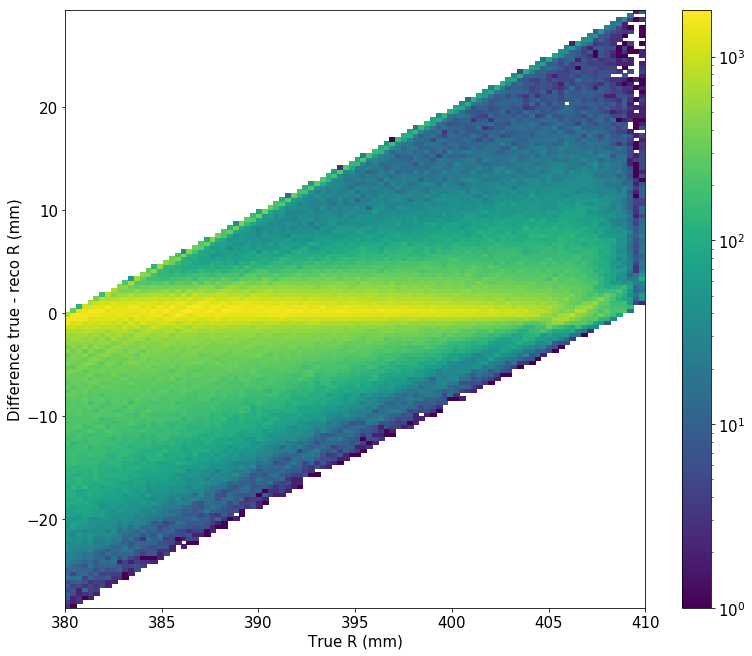

In [124]:
## not photoelectric-like events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r[sel_compt_like], \
                                            diff_r_matrix[sel_compt_like], \
                                            bins=(100, 150), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();

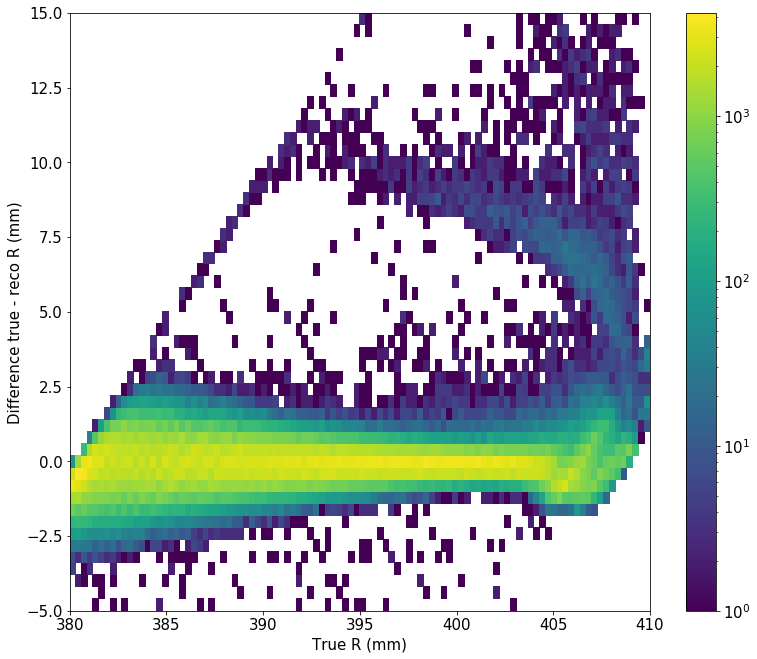

In [125]:
## photoelectric-like events
h_r, xedges_r, yedges_r, img_r = plt.hist2d(true_r[sel_phot_like], \
                                            diff_r_matrix[sel_phot_like], \
                                            bins=(100, 50), range=((380, 410), (-5, 15)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True R (mm)');
plt.colorbar();

In [39]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_r[0]; xmin = np.array(xmin)
ymin = yedges_r[0]; ymin = np.array(ymin)
dx = xedges_r[1:]-xedges_r[:-1]; dx = np.array(dx[0])
dy = yedges_r[1:]-yedges_r[:-1]; dy = np.array(dy[0])
np.savez("errmat_r_compt_like.npz", errmat=h_r, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

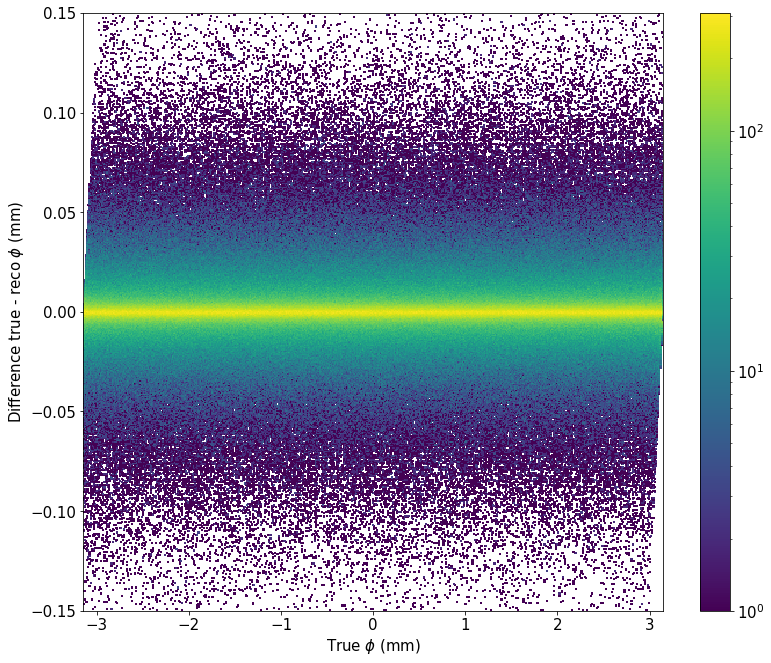

In [173]:
h_phi, xedges_phi, yedges_phi, img_phi = plt.hist2d(true_phi[sel_compt_like], diff_phi_matrix[sel_compt_like],
                                                    bins=(500, 500), range=((-3.15, 3.15), (-0.15, 0.15)), #cmin=1)
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (mm)')
plt.xlabel('True $\phi$ (mm)');
plt.colorbar();
#plt.ylim(-0.02, 0.02)

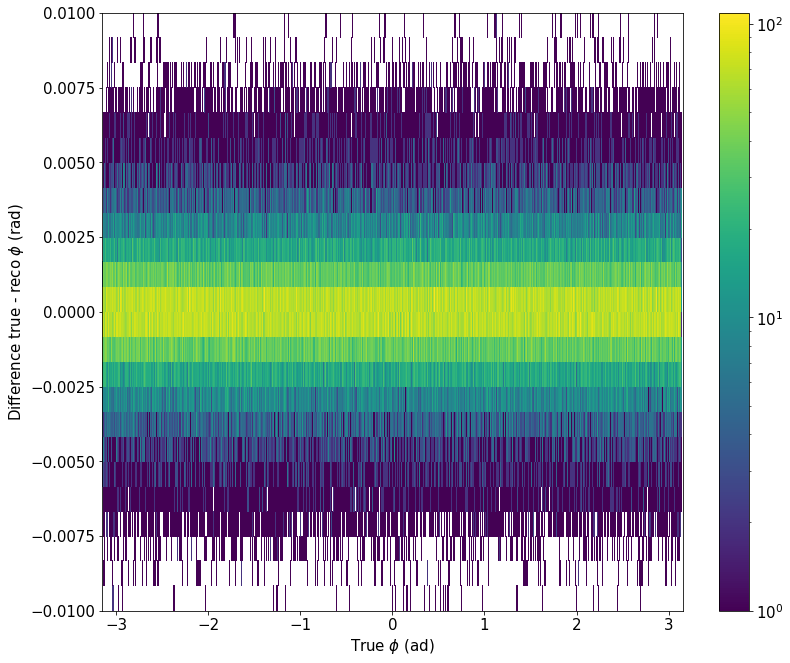

In [174]:
h_phi, xedges_phi, yedges_phi, img_phi = plt.hist2d(true_phi[sel_phot_like], diff_phi_matrix[sel_phot_like],
                                                    bins=(5166, 24), range=((-3.15, 3.15), (-0.01, 0.01)),# cmin=1)#,
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True $\phi$ (ad)');
plt.colorbar();

In [73]:
np.sum(h_phi,axis=1)

array([284., 802., 870., 887., 865., 893., 845., 857., 868., 873., 903.,
       911., 873., 870., 857., 883., 888., 844., 880., 838., 842., 859.,
       825., 870., 893., 859., 908., 838., 870., 832., 863., 868., 842.,
       829., 872., 882., 819., 873., 873., 882., 839., 897., 835., 855.,
       850., 884., 873., 854., 908., 826., 884., 835., 857., 881., 871.,
       880., 900., 842., 887., 882., 842., 868., 844., 870., 868., 827.,
       882., 915., 851., 881., 893., 862., 822., 872., 819., 905., 846.,
       911., 892., 870., 838., 863., 853., 875., 884., 853., 864., 902.,
       853., 880., 931., 864., 794., 834., 852., 848., 856., 882., 815.,
       863., 866., 871., 894., 913., 860., 869., 870., 827., 880., 837.,
       896., 864., 896., 890., 885., 887., 926., 863., 876., 929., 929.,
       849., 853., 852., 898., 879., 815., 894., 844., 894., 881., 911.,
       853., 884., 898., 848., 806., 893., 873., 956., 860., 932., 825.,
       844., 847., 852., 863., 892., 871., 874., 88

In [70]:
h_phi.shape

(500, 500)

In [76]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_phi[0]; xmin = np.array(xmin)
ymin = yedges_phi[0]; ymin = np.array(ymin)
dx = xedges_phi[1:]-xedges_phi[:-1]; dx = np.array(dx[0])
dy = yedges_phi[1:]-yedges_phi[:-1]; dy = np.array(dy[0])
np.savez("errmat_phi_compt_like.npz", errmat=h_phi, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

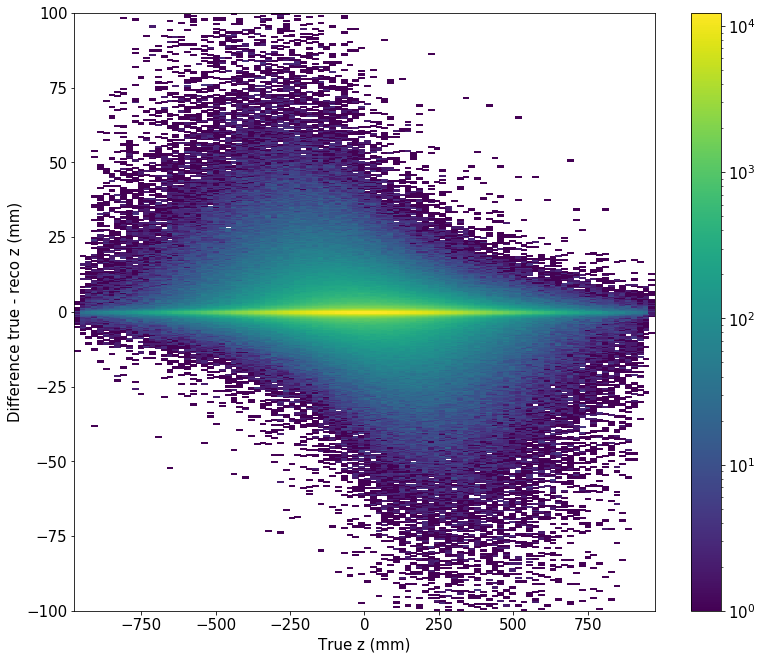

In [129]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z, diff_z_matrix, bins=(100, 500),\
                                                    range=((-975, 975), (-100, 100)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();


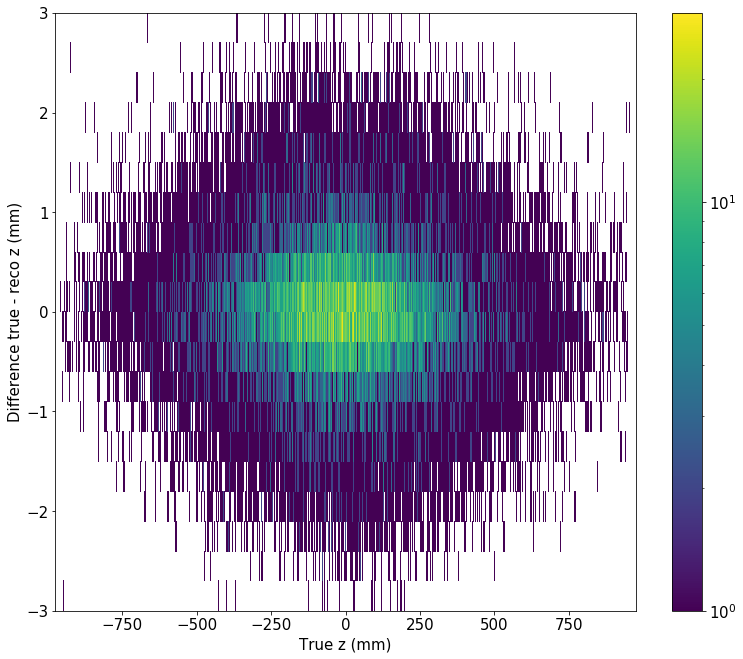

In [17]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z[sel_phot_like], diff_z_matrix[sel_phot_like], bins=(6500, 20),\
                                                    range=((-975, 975), (-3, 3)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

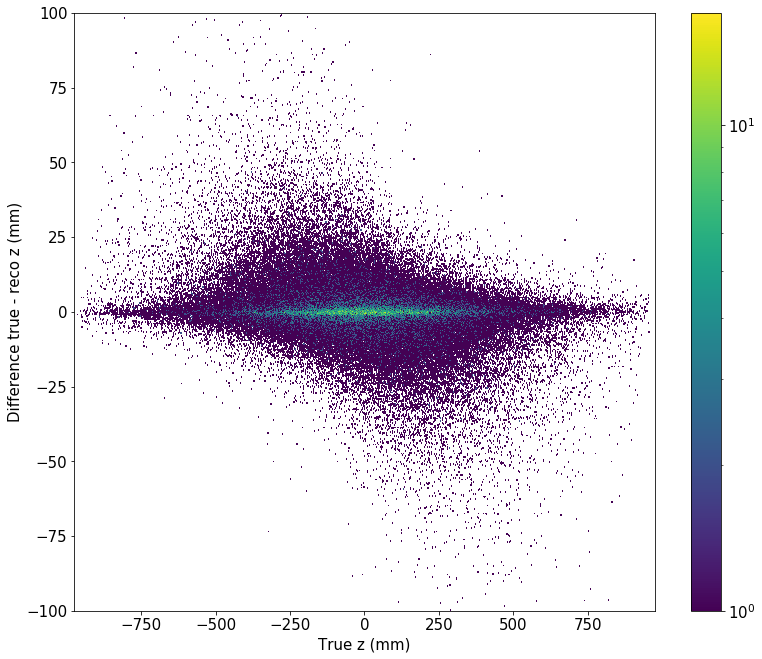

In [18]:
h_z, xedges_z, yedges_z, img_z = plt.hist2d(true_z[sel_compt_like], diff_z_matrix[sel_compt_like], bins=(6500, 667),\
                                                    range=((-975, 975), (-100, 100)),norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

In [81]:
# Save the error matrix for the fast MC.
#eff = len(true_z)/(len(D_true_z1) + len(D_true_z2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_z[0]; xmin = np.array(xmin)
ymin = yedges_z[0]; ymin = np.array(ymin)
dx = xedges_z[1:]-xedges_z[:-1]; dx = np.array(dx[0])
dy = yedges_z[1:]-yedges_z[:-1]; dy = np.array(dy[0])
np.savez("errmat_z_compt_like.npz", errmat=h_z, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

In [113]:
np.sum(h_z,axis=1)

array([6.000e+00, 4.000e+00, 7.000e+00, 1.000e+01, 8.000e+00, 7.000e+00,
       6.000e+00, 8.000e+00, 7.000e+00, 1.200e+01, 1.700e+01, 1.100e+01,
       1.400e+01, 1.500e+01, 1.400e+01, 2.300e+01, 1.600e+01, 1.900e+01,
       1.000e+01, 2.300e+01, 1.400e+01, 2.000e+01, 1.400e+01, 3.000e+01,
       1.100e+01, 1.500e+01, 1.200e+01, 1.600e+01, 1.600e+01, 2.600e+01,
       2.700e+01, 1.900e+01, 2.100e+01, 1.700e+01, 2.100e+01, 2.700e+01,
       2.700e+01, 2.400e+01, 2.400e+01, 2.400e+01, 3.900e+01, 3.300e+01,
       3.700e+01, 3.300e+01, 3.800e+01, 3.800e+01, 4.200e+01, 3.900e+01,
       4.600e+01, 4.500e+01, 4.300e+01, 4.800e+01, 5.100e+01, 5.500e+01,
       5.900e+01, 5.900e+01, 6.800e+01, 6.600e+01, 6.900e+01, 6.100e+01,
       9.200e+01, 8.000e+01, 8.200e+01, 8.500e+01, 9.800e+01, 8.800e+01,
       1.050e+02, 9.900e+01, 1.000e+02, 1.020e+02, 1.240e+02, 1.140e+02,
       1.010e+02, 1.350e+02, 1.280e+02, 1.230e+02, 1.200e+02, 1.420e+02,
       1.460e+02, 1.390e+02, 1.520e+02, 1.600e+02, 

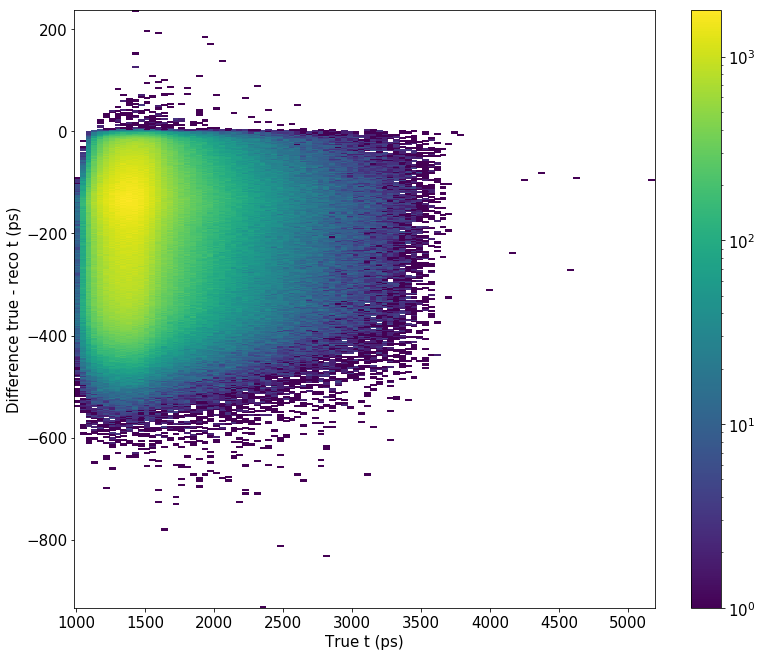

In [132]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t, diff_t_matrix, bins=(100, 500),\
                                                    norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();



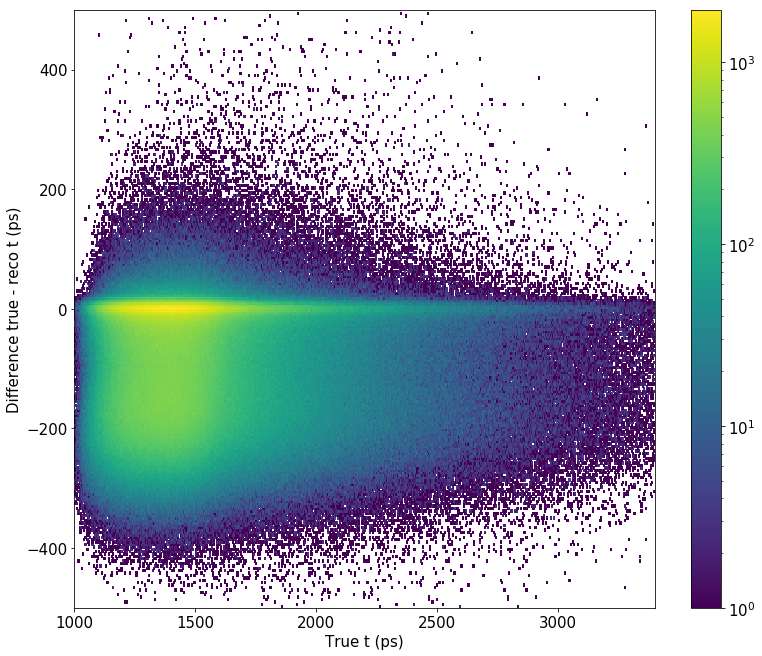

In [171]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t, diff_reco_t_matrix, bins=(500, 250),\
                                                    range=((1000, 3400), (-500, 500)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();
#plt.ylim(-10, 10)

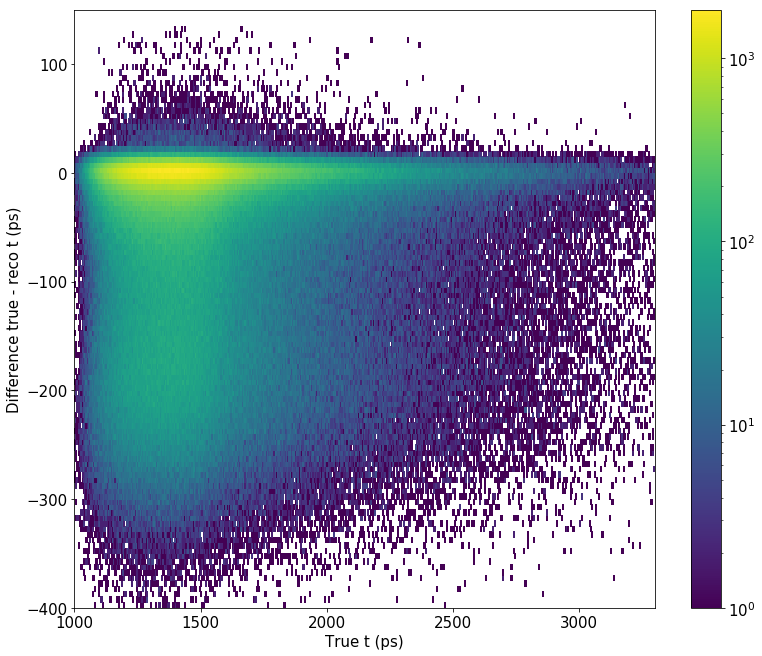

In [172]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t[sel_phot_like], diff_reco_t_matrix[sel_phot_like], bins=(460, 110),\
                                                    range=((1000, 3300), (-400, 150)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();

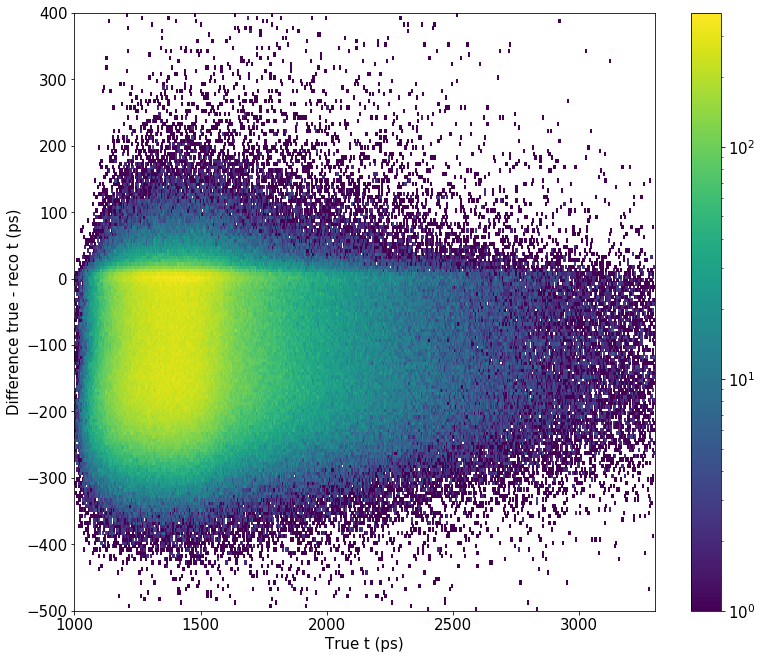

In [155]:
h_t, xedges_t, yedges_t, img_t = plt.hist2d(true_t[sel_compt_like], diff_reco_t_matrix[sel_compt_like], bins=(460, 180),\
                                                    range=((1000, 3300), (-500, 400)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco t (ps)')
plt.xlabel('True t (ps)');
plt.colorbar();

In [124]:
np.sum(h_t,axis=1)

array([   8.,   11.,   19.,   33.,   30.,   52.,   66.,   97.,  114.,
        131.,  142.,  201.,  218.,  235.,  285.,  334.,  368.,  413.,
        460.,  510.,  535.,  592.,  679.,  679.,  684.,  794.,  795.,
        833.,  933.,  994., 1096., 1041., 1125., 1182., 1232., 1245.,
       1276., 1299., 1351., 1398., 1474., 1562., 1561., 1567., 1691.,
       1688., 1751., 1818., 1728., 1833., 1917., 1863., 1871., 1996.,
       1922., 2028., 2124., 1987., 2019., 2077., 2125., 2135., 2192.,
       2142., 2258., 2209., 2222., 2280., 2270., 2311., 2310., 2324.,
       2275., 2366., 2375., 2408., 2352., 2402., 2453., 2458., 2511.,
       2367., 2423., 2360., 2450., 2390., 2446., 2430., 2437., 2391.,
       2481., 2346., 2422., 2375., 2383., 2330., 2379., 2292., 2353.,
       2316., 2284., 2312., 2318., 2303., 2174., 2287., 2174., 2105.,
       2091., 2148., 2065., 2003., 1943., 2035., 1909., 1896., 1850.,
       1903., 1771., 1681., 1640., 1679., 1637., 1557., 1512., 1508.,
       1452., 1385.,

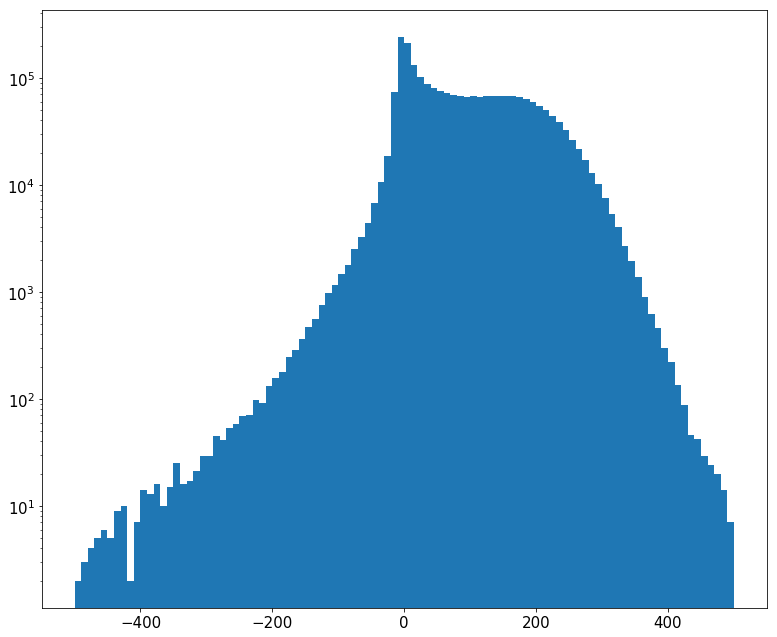

In [160]:
g = plt.hist(-diff_reco_t_matrix, bins=100, range=(-500, 500))
plt.yscale('log')

In [110]:
# Save the error matrix for the fast MC.
#eff = len(true_t)/(len(D_true_t1) + len(D_true_t2)); eff = np.array(eff)
eff = np.array([1])
xmin = xedges_t[0]; xmin = np.array(xmin)
ymin = yedges_t[0]; ymin = np.array(ymin)
dx = xedges_t[1:]-xedges_t[:-1]; dx = np.array(dx[0])
dy = yedges_t[1:]-yedges_t[:-1]; dy = np.array(dy[0])
np.savez("errmat_t_compt_like.npz", errmat=h_t, eff=eff, xmin=xmin, ymin=ymin, dx=dx, dy=dy)

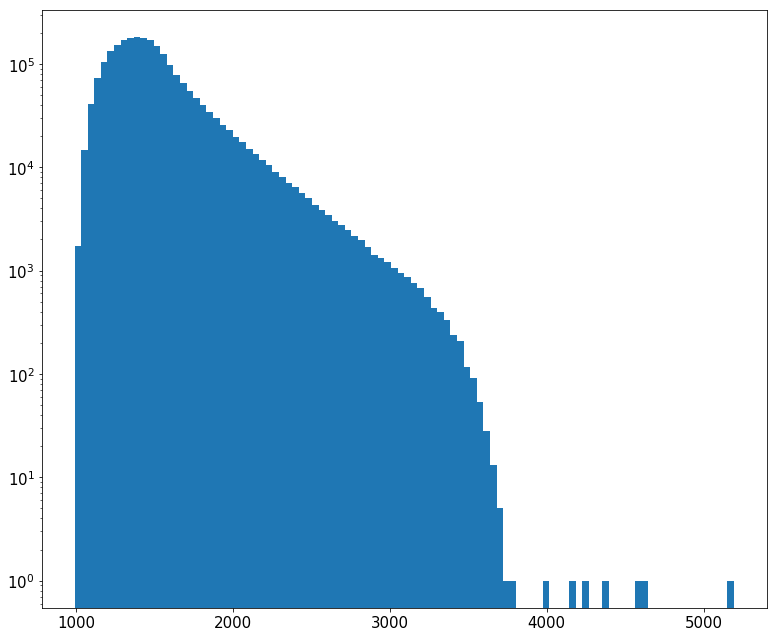

In [136]:
h = plt.hist(true_t, bins=100)
plt.yscale('log');

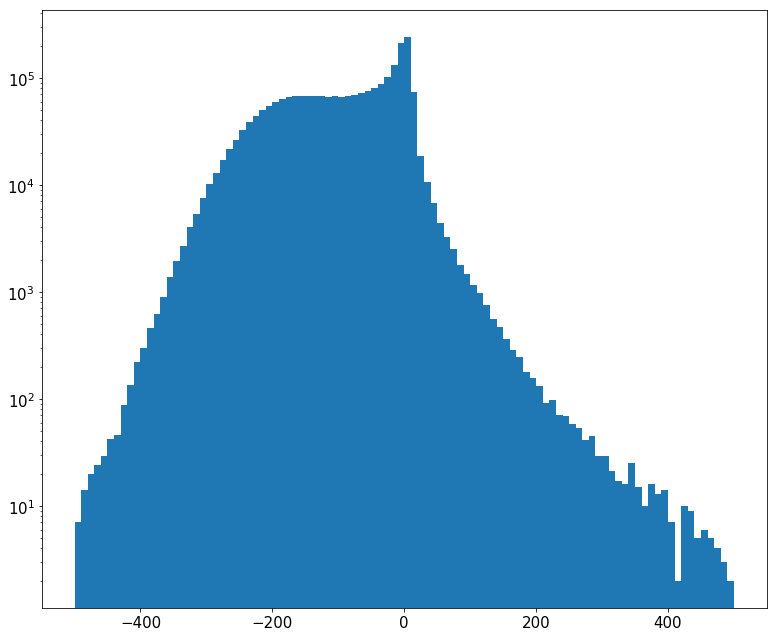

In [137]:
h = plt.hist(diff_reco_t_matrix, bins=100, range=(-500, 500))
plt.yscale('log');

## Correlations

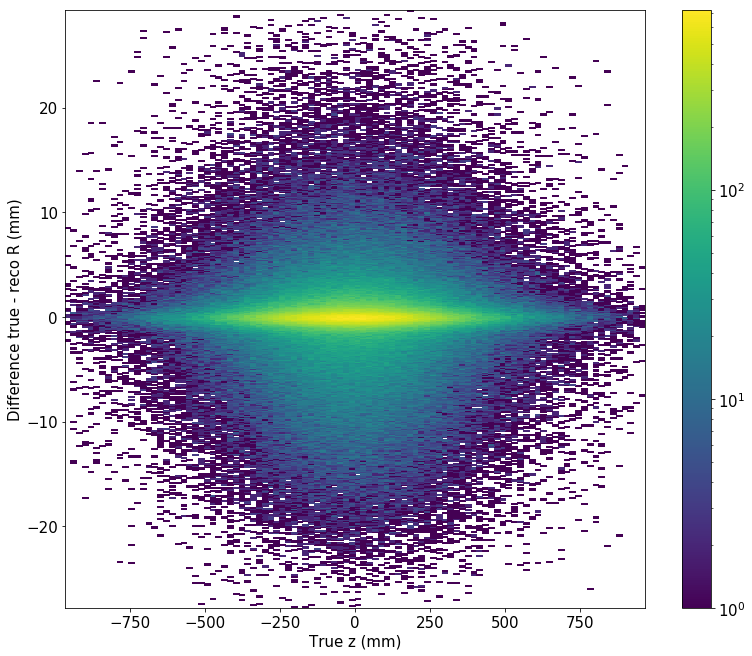

In [126]:
plt.hist2d(true_z, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

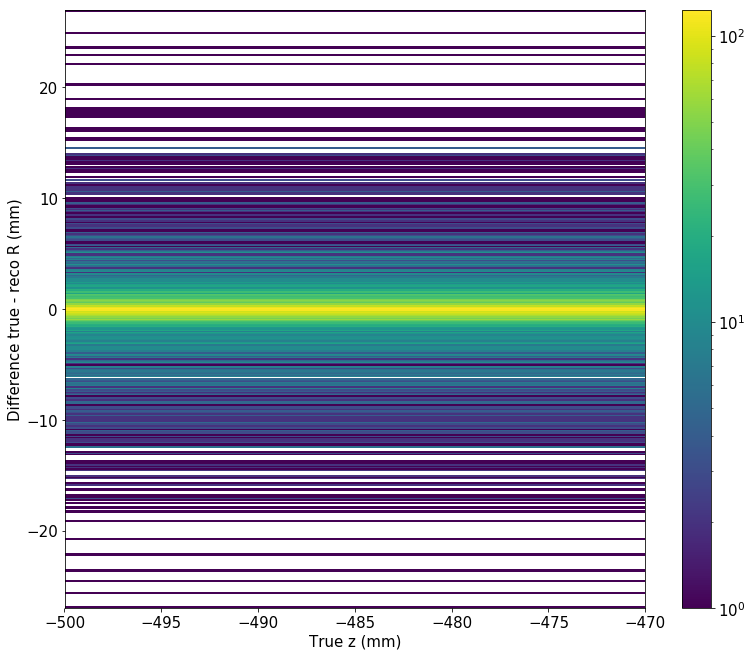

In [127]:
slice1    = (true_z>-500) & (true_z<-470)
z_sl1     = true_z[slice1]
err_r_sl1 = diff_r_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(z_sl1, err_r_sl1, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

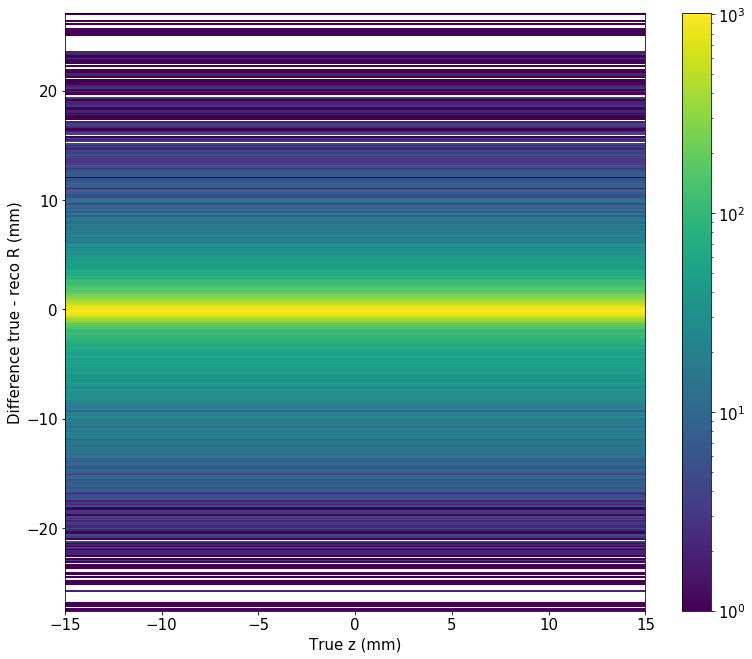

In [128]:
slice2    = (true_z>-15) & (true_z<15)
z_sl2     = true_z[slice2]
err_r_sl2 = diff_r_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(z_sl2, err_r_sl2, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

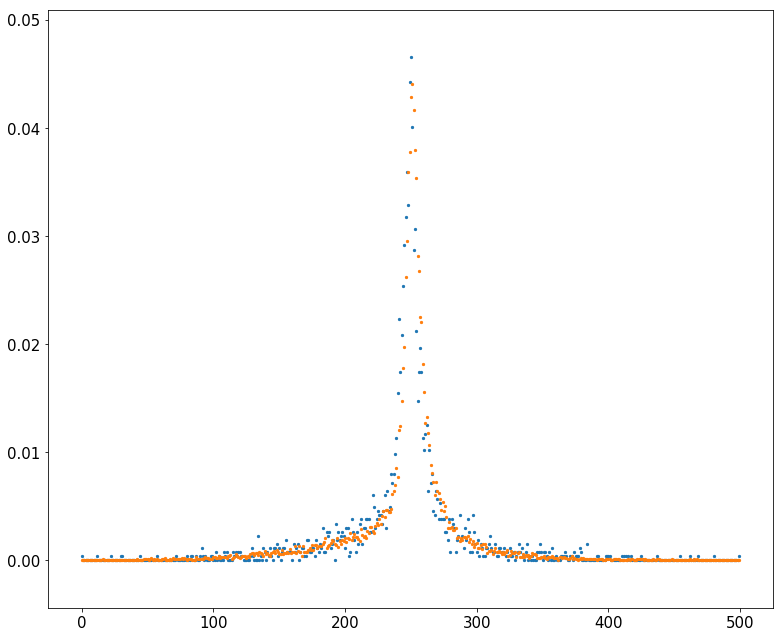

In [129]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5)
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5)

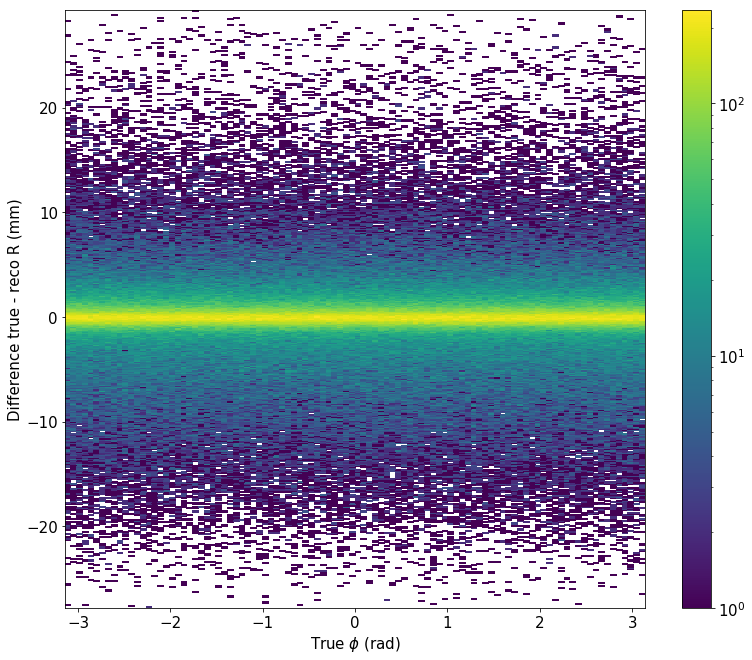

In [130]:
plt.hist2d(true_phi, diff_r_matrix, bins=(100, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True $\phi$ (rad)');
plt.colorbar();

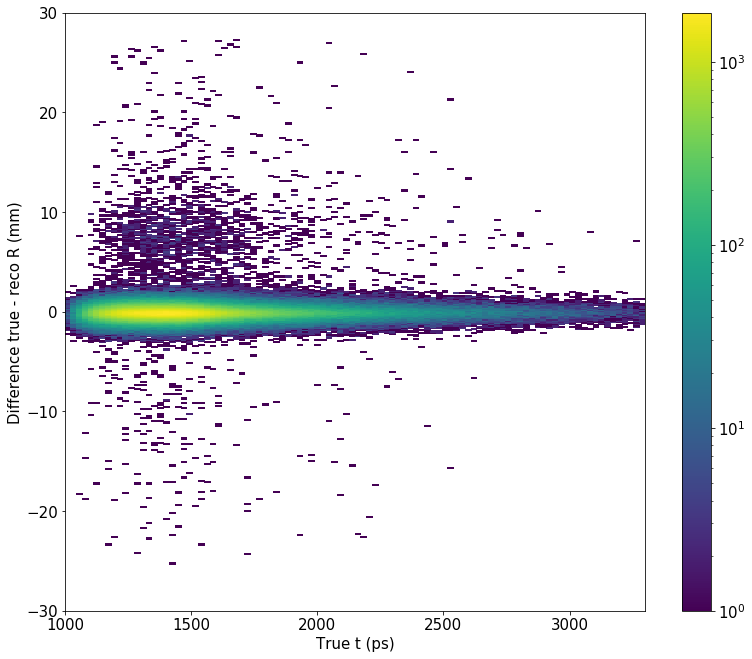

In [92]:
plt.hist2d(true_t[sel_phot_like], diff_r_matrix[sel_phot_like], bins=(100, 500), range=((1000, 3300), (-30, 30)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

In [94]:
true_t[sel_phot_like & (true_t>1500) & (true_t<1510) & (true_r>390) & (true_r<390.2)]

array([1505.19955158, 1504.85539436, 1505.30612469, 1509.78279114,
       1506.38663769, 1509.18388367, 1505.40947914, 1501.51312351,
       1508.60536098, 1503.85689735, 1505.50234318, 1502.02453136,
       1508.26895237, 1506.1314106 , 1505.01322746, 1505.26595116,
       1507.47299194, 1503.7266016 , 1501.46079063, 1506.48379326,
       1501.74331665, 1502.72083282, 1506.49666786, 1505.95545769,
       1505.95283508, 1506.08336926, 1501.87408924, 1505.17082214,
       1504.75227833, 1504.30881977, 1508.66949558, 1505.11169434,
       1501.00028515, 1505.84387779, 1502.32005119, 1507.83216953,
       1508.96811485, 1508.26013088, 1500.54752827, 1505.49614429,
       1502.46417522, 1507.36820698, 1508.14723969, 1507.5173378 ,
       1503.24034691, 1501.50263309, 1500.88500977, 1506.58035278,
       1509.23275948, 1507.1413517 , 1503.14366817, 1507.15172291,
       1505.0765276 , 1504.44114208, 1503.06940079, 1505.81979752,
       1500.19061565])

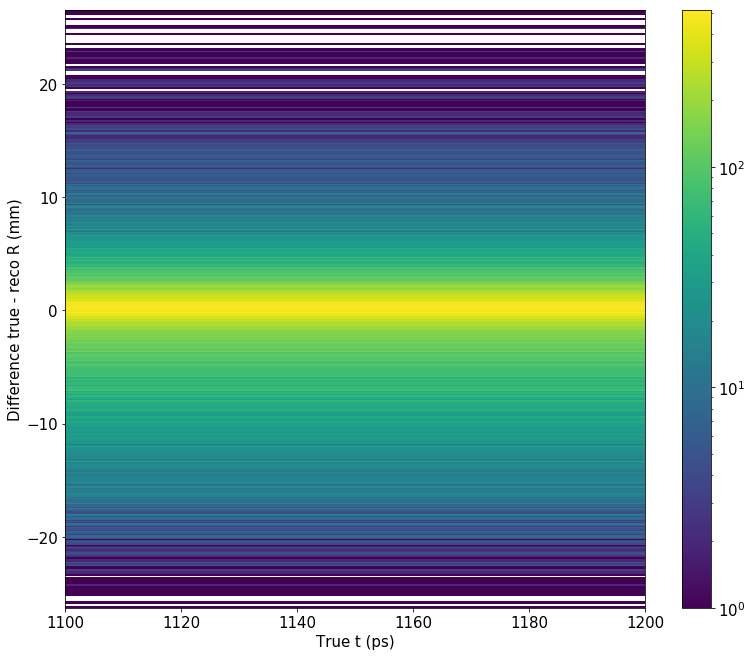

In [166]:
slice1    = (true_t>1100) & (true_t<1200) & sel_compt_like
t_sl1     = true_t[slice1]
err_r_sl1 = diff_r_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(t_sl1, err_r_sl1, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

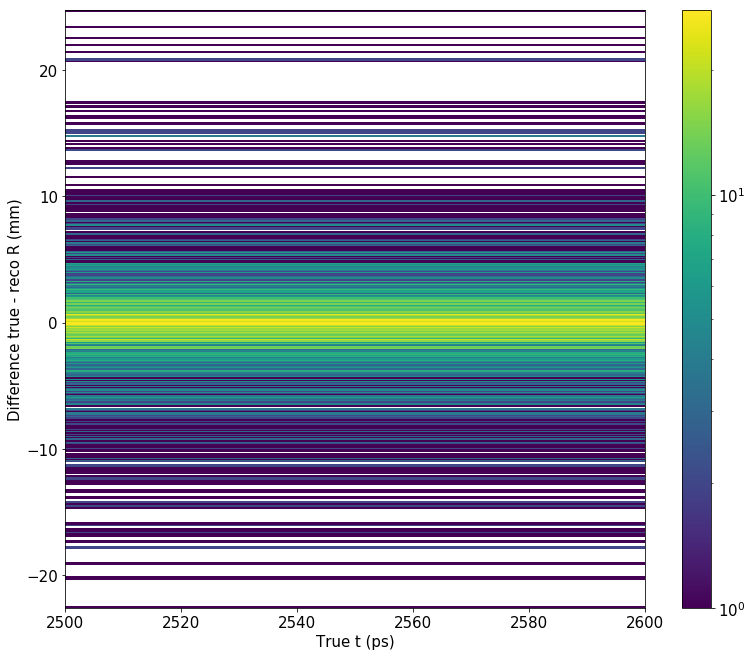

In [167]:
slice2    = (true_t>2500) & (true_t<2600) & sel_compt_like
t_sl2     = true_t[slice2]
err_r_sl2 = diff_r_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(t_sl2, err_r_sl2, bins=(1, 500), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True t (ps)');
plt.colorbar();

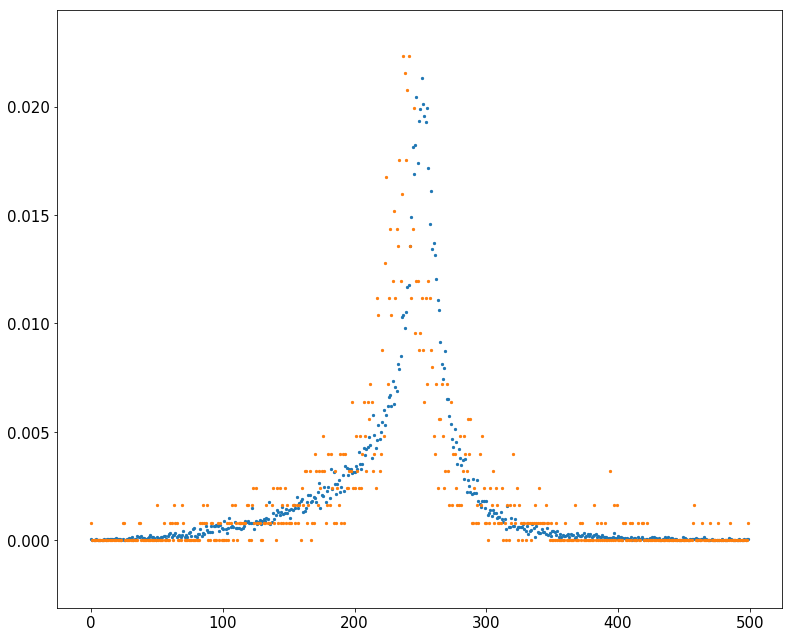

In [168]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5)
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5)

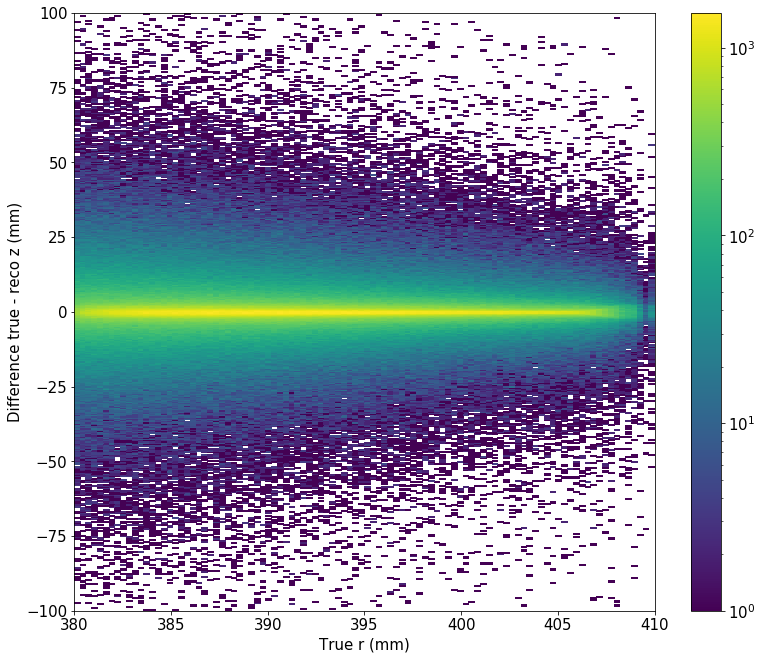

In [149]:
plt.hist2d(true_r[sel_compt_like], diff_z_matrix[sel_compt_like], bins=(100, 500), \
           range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True r (mm)');
plt.colorbar();

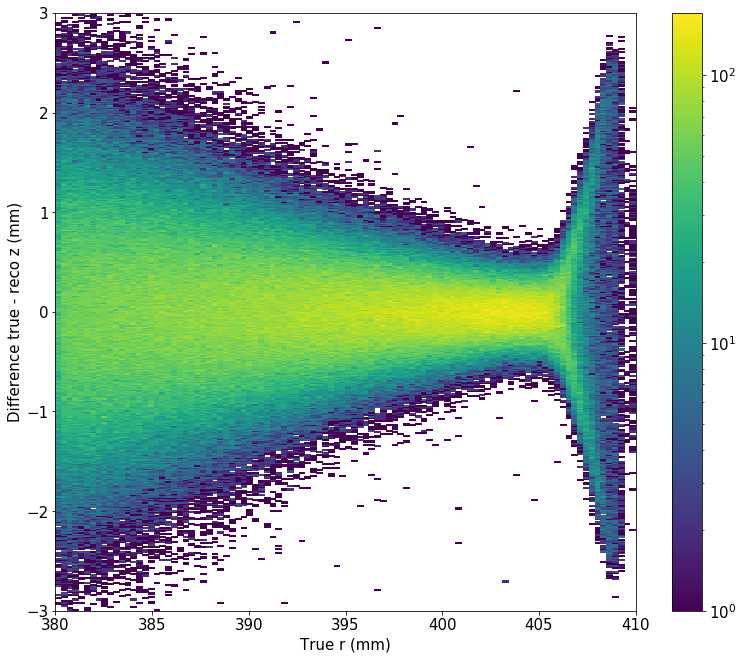

In [152]:
plt.hist2d(true_r[sel_phot_like], diff_z_matrix[sel_phot_like], bins=(100, 500), \
           range=((380, 410), (-3, 3)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True r (mm)');
plt.colorbar();

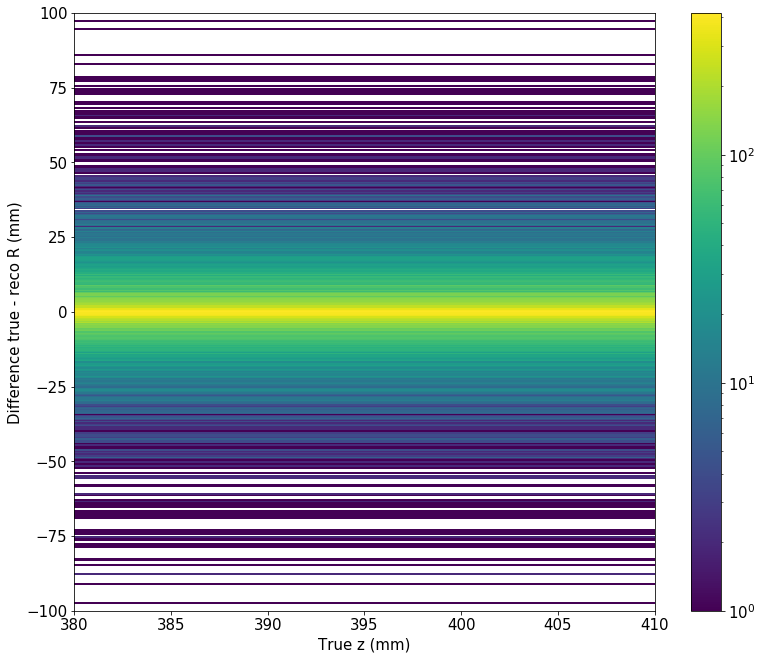

In [145]:
slice1    = (true_r>380) & (true_r<381) & sel_compt_like
r_sl1     = true_r[slice1]
err_z_sl1 = diff_z_matrix[slice1]

h1, xedges, yedges, img = plt.hist2d(r_sl1, err_z_sl1, bins=(1, 500), range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

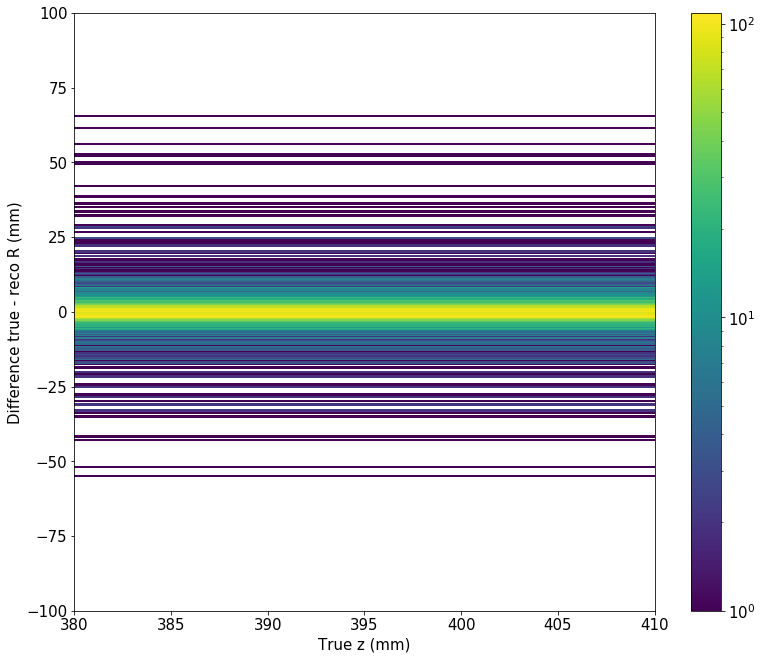

In [146]:
slice2    = (true_r>408) & (true_r<409) & sel_compt_like
r_sl2     = true_r[slice2]
err_z_sl2 = diff_z_matrix[slice2]

h2, xedges, yedges, img = plt.hist2d(r_sl2, err_z_sl2, bins=(1, 500), range=((380, 410), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco R (mm)')
plt.xlabel('True z (mm)');
plt.colorbar();

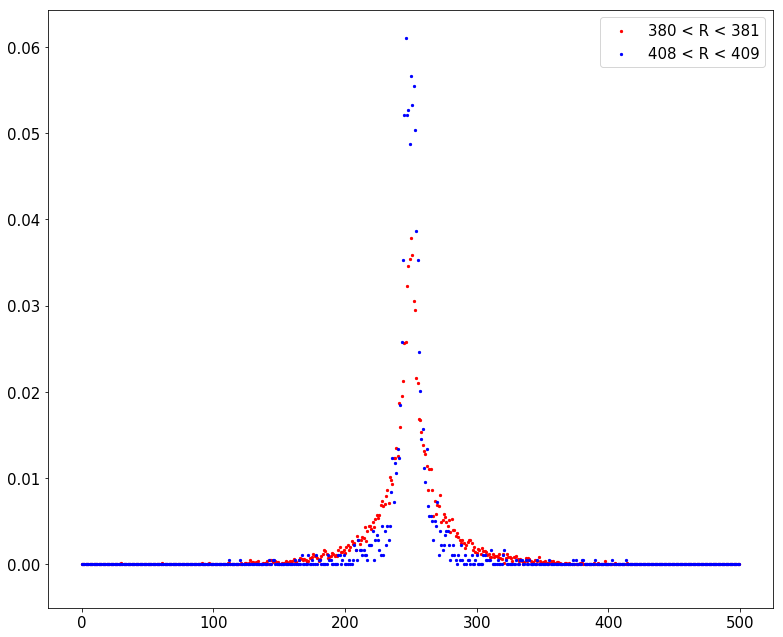

In [147]:
plt.scatter(list(range(len(h1[0]))), h1[0]/h1[0].sum(), s=5, c='red', label='380 < R < 381')
plt.scatter(list(range(len(h2[0]))), h2[0]/h2[0].sum(), s=5, c='blue', label='408 < R < 409')
plt.legend(loc=1)

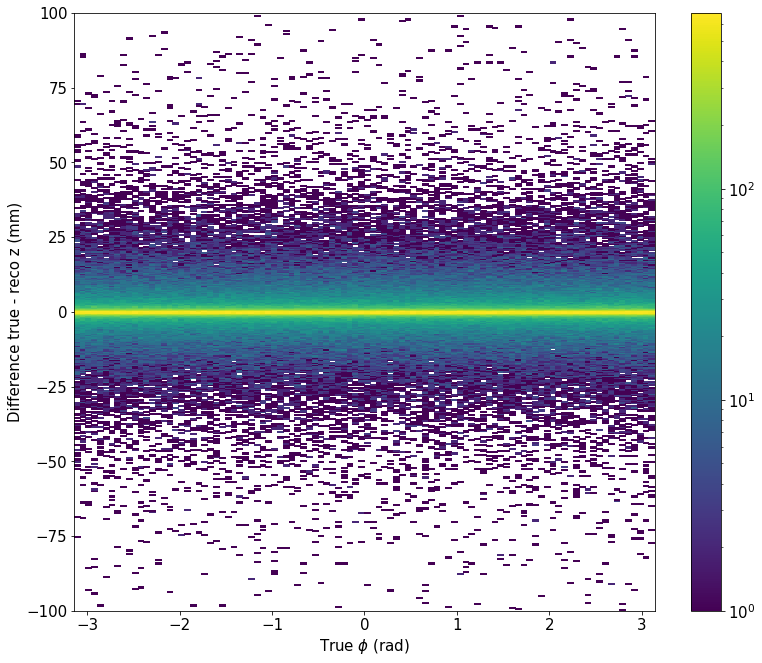

In [136]:
plt.hist2d(true_phi, diff_z_matrix, bins=(100, 500), range=((-3.14, 3.14), (-100, 100)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco z (mm)')
plt.xlabel('True $\phi$ (rad)');
plt.colorbar();

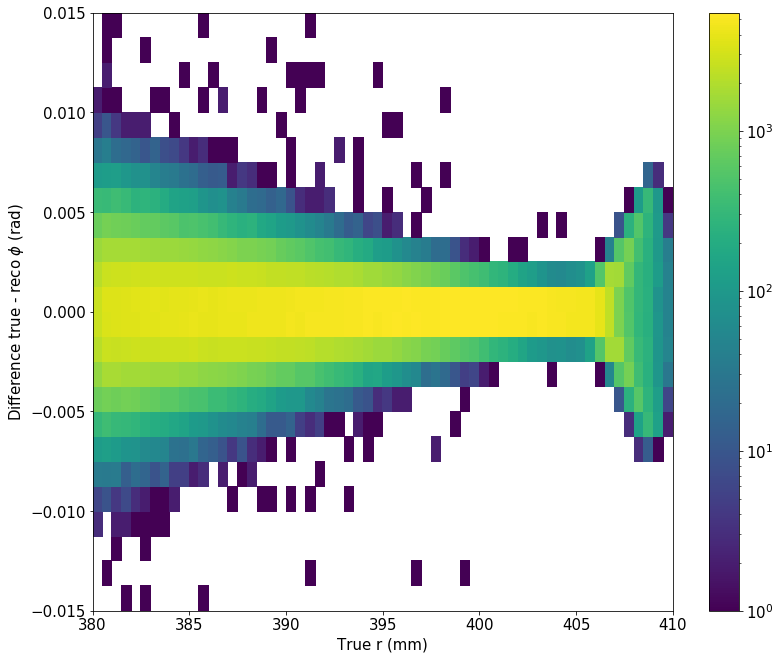

In [148]:
plt.hist2d(true_r[sel_phot_like], diff_phi_matrix[sel_phot_like], bins=(60, 24), 
           range=((380, 410), (-0.015, 0.015)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True r (mm)');
plt.colorbar();

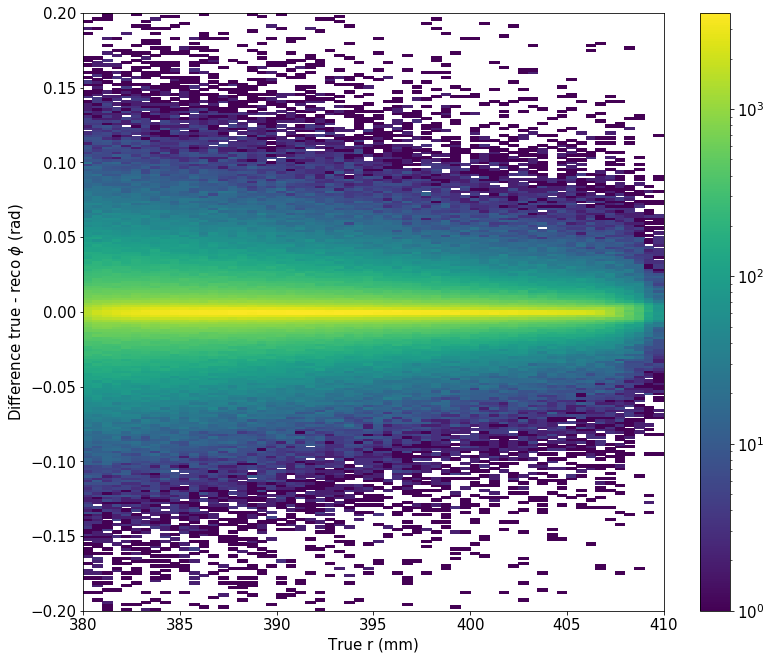

In [147]:
plt.hist2d(true_r[sel_compt_like], diff_phi_matrix[sel_compt_like], bins=(60, 246), 
           range=((380, 410), (-0.2, 0.2)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True r (mm)');
plt.colorbar();

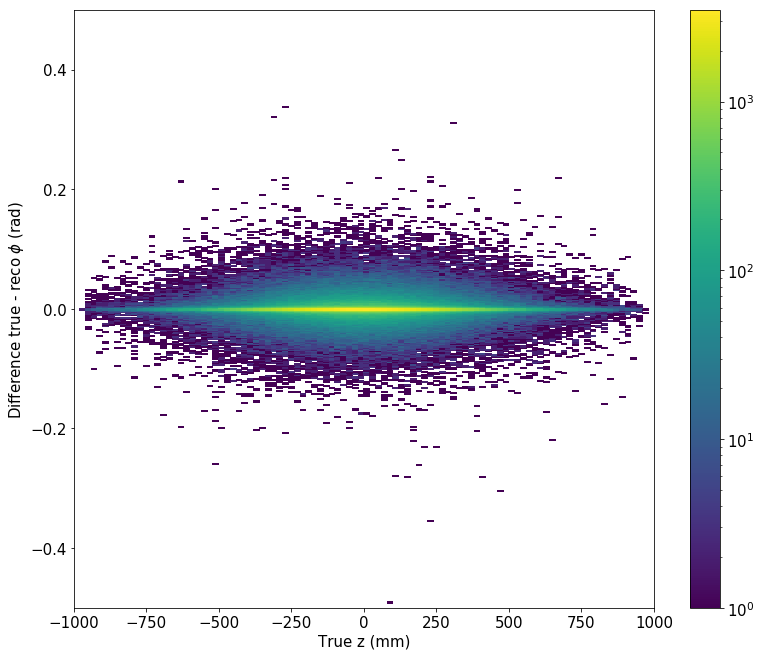

In [149]:
plt.hist2d(true_z, diff_phi_matrix, bins=(100, 500), range=((-1000, 1000), (-0.5, 0.5)), norm=mp_colors.LogNorm())
plt.ylabel('Difference true - reco $\phi$ (rad)')
plt.xlabel('True z (mm)');
plt.colorbar();

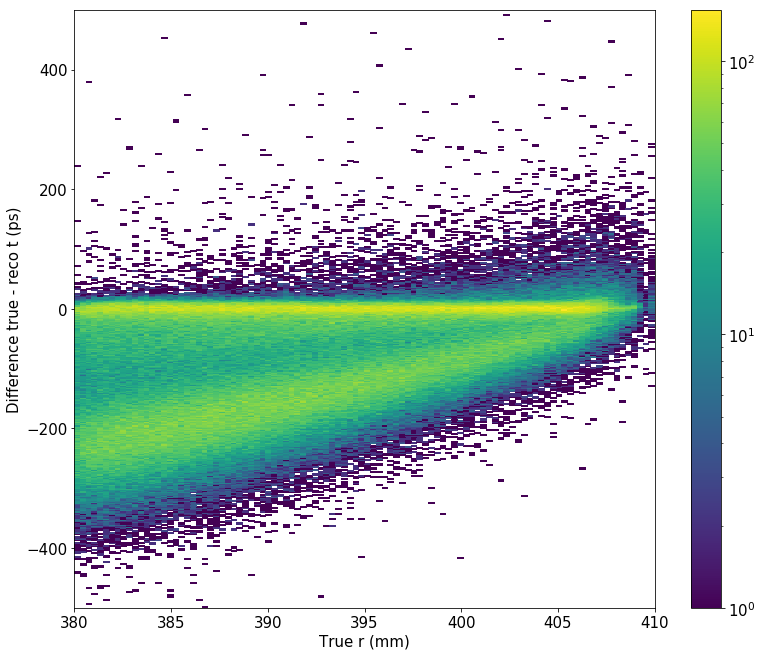

In [150]:
plt.hist2d(true_r, diff_reco_t_matrix, bins=(100, 500), range=((380, 410), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

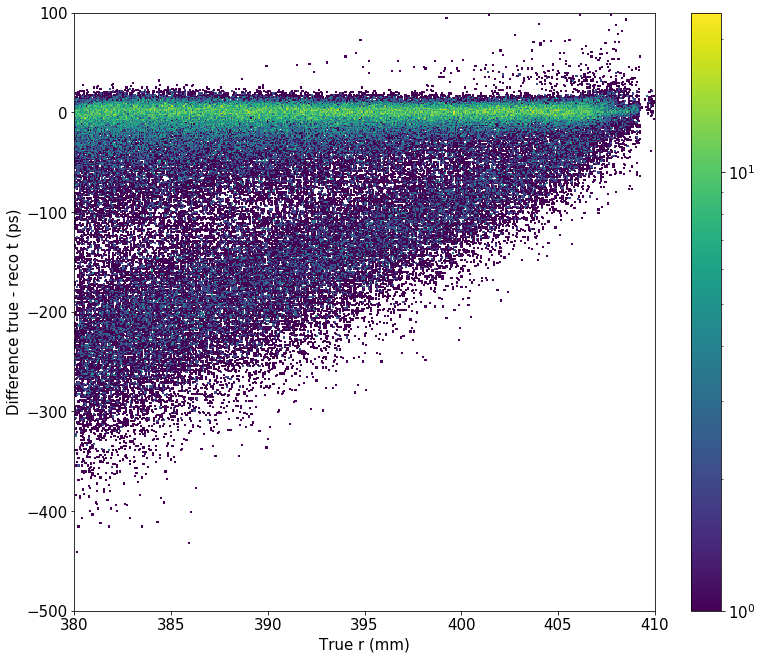

In [153]:
plt.hist2d(true_r[sel_phot_like], \
           diff_reco_t_matrix[sel_phot_like], \
           bins=(500, 500), range=((380, 410), (-500, 100)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

In [87]:
var = true_t2 - reco_t2
phot_evts = events[phot2 == True]
print(phot_evts[var[phot2 == True] < -200])

[5.10062165e+08 5.10090793e+08 5.10120105e+08 5.10150523e+08
 5.10150808e+08 5.10151292e+08 5.10300217e+08 5.10330689e+08
 5.10331714e+08 5.10361135e+08 5.10511635e+08 5.10540101e+08
 5.10540401e+08 5.10570872e+08 5.10571191e+08 5.10572206e+08
 5.10600852e+08 5.10602138e+08 5.10602145e+08 5.10631896e+08
 5.10661543e+08 5.10690519e+08 5.10900037e+08 5.10900730e+08
 5.10901434e+08 5.10960802e+08 5.10961647e+08 5.11022133e+08
 5.11081061e+08 5.11081479e+08 5.11170782e+08 5.11351805e+08
 5.11381171e+08 5.11410259e+08 5.11411886e+08 5.11440483e+08
 5.11441159e+08 5.11500617e+08 5.11500760e+08 5.11592380e+08
 5.11740184e+08 5.11771670e+08 5.11772354e+08 5.11861557e+08
 5.11862139e+08 5.11891537e+08 5.11922347e+08 5.11950903e+08
 5.12040241e+08 5.12041064e+08 5.12070800e+08 5.12130118e+08
 5.12161137e+08 5.12161230e+08 5.12221605e+08 5.12251792e+08
 5.12310042e+08 5.12342225e+08 5.12400993e+08 5.12430173e+08
 5.12460085e+08 5.12491523e+08 5.12520431e+08 5.12581064e+08
 5.12611801e+08 5.126410

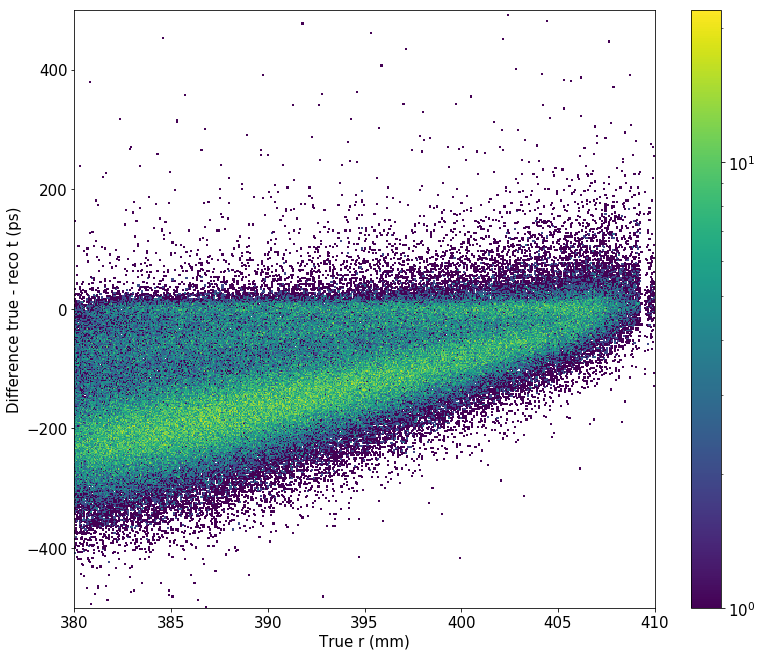

In [155]:
plt.hist2d(true_r[sel_compt_like], \
           diff_reco_t_matrix[sel_compt_like], \
           bins=(500, 500), range=((380, 410), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

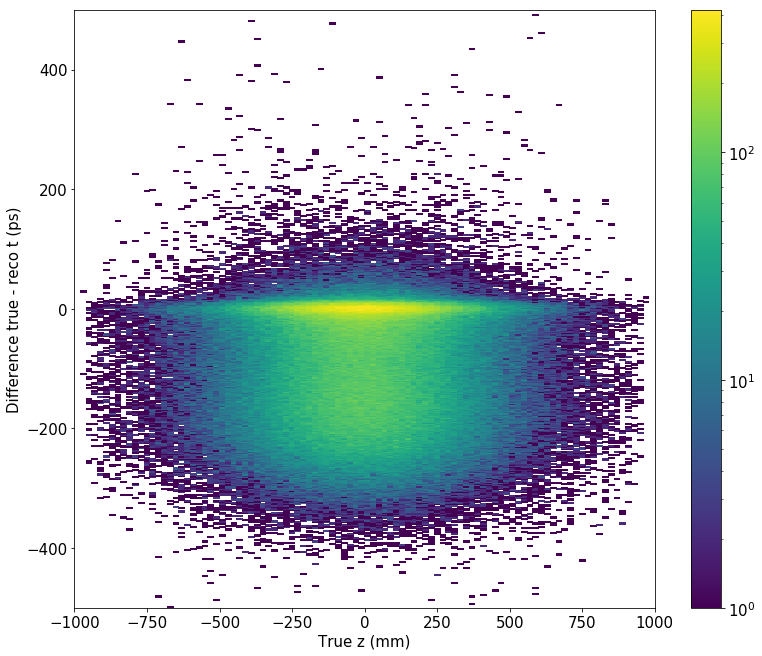

In [57]:
plt.hist2d(true_z, diff_reco_t_matrix, bins=(100, 500), range=((-1000, 1000), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True z (mm)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

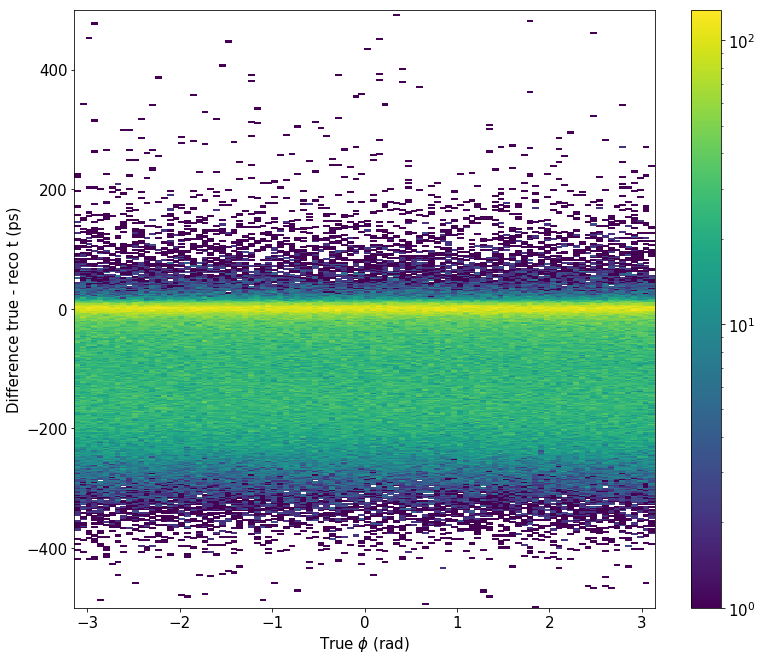

In [58]:
plt.hist2d(true_phi, diff_reco_t_matrix, bins=(100, 500), range=((-3.14, 3.14), (-500, 500)), norm=mp_colors.LogNorm())
plt.xlabel('True $\phi$ (rad)');
plt.ylabel('Difference true - reco t (ps)')
plt.colorbar();

## True-true correlation

In [1]:
plt.hist2d(true_r, true_t, bins=(100, 500), range=((380, 410), (1000, 3300)), norm=mp_colors.LogNorm())
plt.xlabel('True r (mm)')
plt.ylabel('True t (ps)')
plt.colorbar();

NameError: name 'plt' is not defined

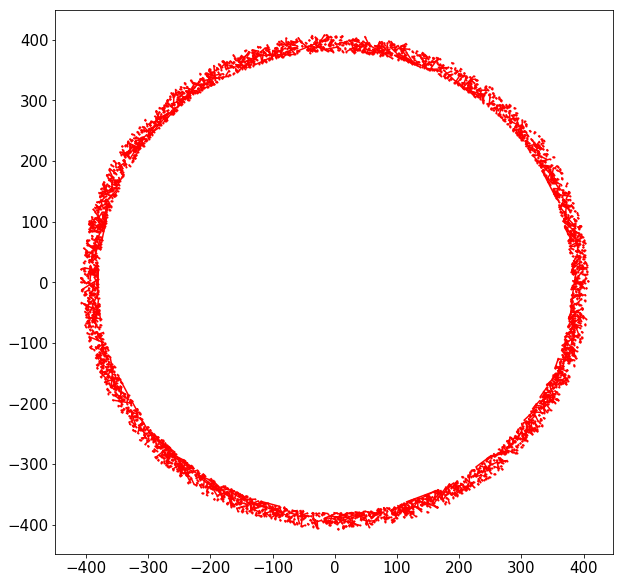

In [59]:
fig = plt.figure(1)
fig.set_figwidth(10.)
fig.set_figheight(10)

for i in range(2000, 5000):
    my_x, my_y = [], []
    my_x.append(reco_x[i:i+1])
    my_x.append(true_x[i:i+1])
    my_y.append(reco_y[i:i+1])
    my_y.append(true_y[i:i+1])
    plt.plot(my_x, my_y, 'ro-', markersize=1)
    
plt.show()